# CV Final Project Notebook
Hailey Pan, Hannah Tao

## Part 1: Generating the Dataset

Since we did not have access to a prior dataset, we used a diffusion model to generate black hole images.

#### Setup

1. First, you must clone the InverseBench repository to be able to access the Diffusion model tools.

    In your terminal, run git clone https://github.com/devzhk/InverseBench.git

2. Then, you should download the blackhole diffusion model here: https://github.com/devzhk/InverseBench/releases/download/diffusion-prior/blackhole-50k.pt

3. Make sure that the repository and .pt model are in the same directory as this .ipynb file

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
from tqdm import tqdm
import sys

In [3]:
sys.path.append('InverseBench')

from utils.scheduler import Scheduler
from utils.diffusion import DiffusionSampler
from models.precond import VPPrecond
from models.unets import SongUNet

### Helper functions

In [7]:
def save_images(images, output_dir):
    """
        saves generated images to the specified output directory
    """

    # create the output directory
    os.makedirs(output_dir, exist_ok=True)
    
    for i, img in enumerate(images):
        # convert tensor to numpy array
        if isinstance(img, torch.Tensor):
            img = img.squeeze().cpu().numpy()
        
        # scale the image
        if img.max() > 1.0:
            img = img / 255.0
        
        # save the image
        plt.figure(figsize=(5, 5))
        plt.imshow(img, cmap='viridis')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'blackhole_{i:03d}.png'), dpi=300, bbox_inches='tight')
        plt.close()
        
        # save as numpy array for further processing
        np.save(os.path.join(output_dir, f'blackhole_{i:03d}.npy'), img)

In [8]:
def create_model_from_checkpoint(checkpoint, device):
    """
        creates a VPPrecond model from the checkpoint
    """
    # use the model parameters based on configs/pretrain/blackhole.yaml (from the InverseBench repo)
    model = VPPrecond(
        img_resolution=64,
        img_channels=1,
        label_dim=0,
        model_type='SongUNet',
        model_channels=128, 
        channel_mult=[1, 2, 2],
        attn_resolutions=[16],
        num_blocks=1,
        dropout=0.0
    ).to(device)
    
    # extract state dict from the checkpoint
    if 'ema' in checkpoint:
        state_dict = checkpoint['ema']
    elif 'net' in checkpoint:
        state_dict = checkpoint['net']
    else:
        state_dict = checkpoint
    
    # load state dictionary
    model.load_state_dict(state_dict)
    
    return model

In [9]:
def generate_samples(model, num_samples, img_resolution, steps, device, schedule='linear', timestep='poly-7', scaling='none'):
    """
        generates num_samples images using the diffusion model
    """

    # create scheduler. this will be used to sample the models
    scheduler = Scheduler(
        num_steps=steps,
        sigma_max=80.0,
        sigma_min=0.002,
        schedule=schedule,
        timestep=timestep,
        scaling=scaling
    )
    
    # initialize the model
    sampler = DiffusionSampler(scheduler)
    
    # create starting noise
    x_start = torch.randn(
        num_samples, 
        model.img_channels, 
        img_resolution, 
        img_resolution, 
        device=device
    ) * scheduler.sigma_max
    
    print(f"generating {num_samples} images...")
    with torch.no_grad():
        # sample from the diffusion model
        model.eval()
        samples = sampler.sample(model, x_start, SDE=False, verbose=True)
    
    # normalize samples to [0, 1]
    samples = (samples - samples.min()) / (samples.max() - samples.min())
    
    return samples

#### Configure and run the diffusion model

In [19]:
config = {
    'model_path': 'blackhole-50k.pt',
    'num_samples': 1,
    'output_dir': 'generated_blackholes',
    'image_size': 64,
    'steps': 200,
    'seed': 42,
    'schedule': 'linear',
    'timestep': 'poly-7',
    'scaling': 'none'
}
    
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")
    
# load the pretrained model
print(f"loading model from {config['model_path']}")
checkpoint = torch.load(config['model_path'], map_location=device)
    

using device: cpu
loading model from blackhole-50k.pt


In [26]:
# create the model
model = create_model_from_checkpoint(checkpoint, device)
model.eval()

samples = generate_samples(
    model, 
    config['num_samples'], 
    config['image_size'], 
    config['steps'], 
    device,
    schedule=config['schedule'],
    timestep=config['timestep'],
    scaling=config['scaling']
)        
        
print(f"saving images to {config['output_dir']}")
save_images(samples, config['output_dir'])
print(f"saved {len(samples)} images")

generating 1 images...


Sampling: 100%|██████████| 200/200 [00:18<00:00, 10.96it/s]


saving images to generated_blackholes
saved 1 images


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

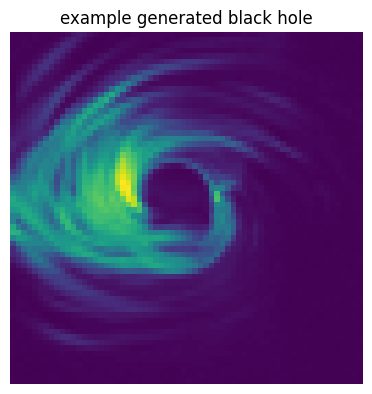

In [25]:
# display an example
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(samples[0].squeeze().cpu().numpy(), cmap='viridis')
plt.title("example generated black hole")
plt.axis('off')